## Data Loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd 'drive/My Drive/project/'
% ls

/content/drive/My Drive/project
EEG_loading.ipynb  person_train_valid.npy  X_train_valid.npy  y_train_valid.npy
person_test.npy    X_test.npy              y_test.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.4.1


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769

In [ ]:
from keras.utils import to_categorical
y_train_valid = keras.utils.to_categorical(y_train_valid)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Data Preprocessing

In [ ]:
from scipy.signal import savgol_filter

def add_gaussian(X, mean=0, std=0.3):
    return X + np.random.normal(loc=mean, scale=std, size=X.shape)

def filtering(X):
    return savgol_filter(X,11,3)

In [ ]:
X_train_gaussian = add_gaussian(X_train_valid, std=2)
X_train_filtered = savgol_filter(X_train_valid,11,3)

X_train_aug = np.concatenate((X_train_valid,X_train_gaussian,X_train_filtered), axis=0)
y_train_aug =  np.concatenate((y_train_valid,y_train_valid,y_train_valid), axis=0)
print(X_train_aug.shape,y_train_aug.shape)

(6345, 22, 1000) (6345, 4)


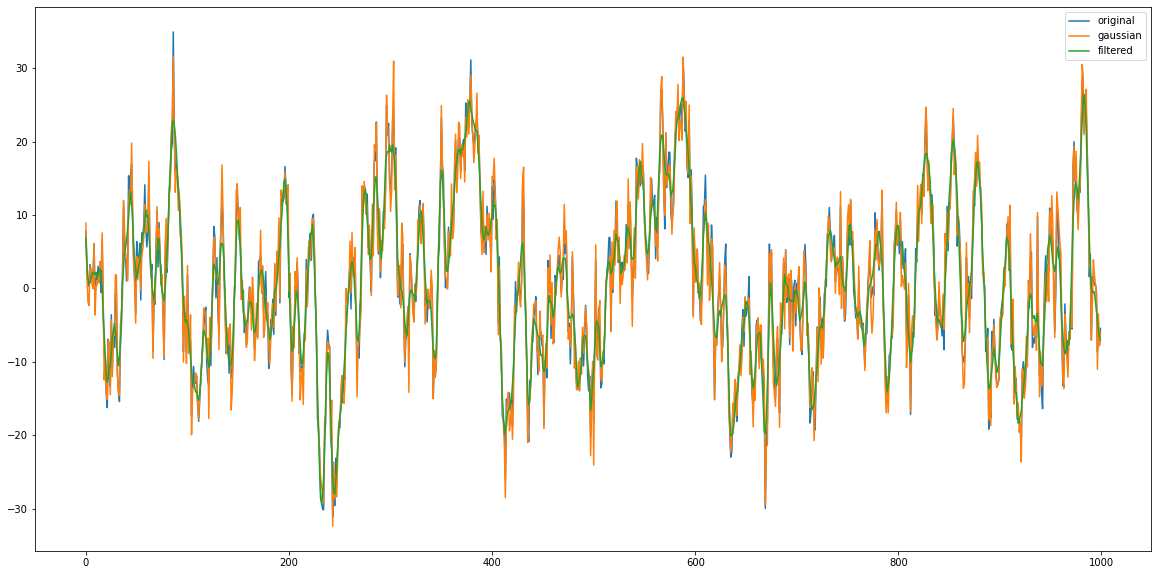

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(X_train_valid[(0,3)], label="original")
plt.plot(X_train_gaussian[(0,3)], label="gaussian")
plt.plot(X_train_filtered[(0,3)], label="filtered")
plt.legend()
plt.show()

## Train

In [ ]:
from keras.initializers import lecun_uniform
def train(model_type = None, sub_idx=None, time_period=1000, data=None, num_epoch=20, plot=True):
    # different period of time
    X_train_ = data['X_train'][:, :, :time_period]
    X_test_ = data['X_test'][:, :, :time_period]
    y_train_ = data['y_train']
    y_test_ = data['y_test']

    # single subject dataset
    if sub_idx is not None:
        X_train_ = X_train_[np.where(person_train_valid == sub_idx)[0]]
        y_train_ = y_train_[np.where(person_train_valid == sub_idx)[0]]
        X_test_ = X_test_[np.where(person_test == sub_idx)[0]]
        y_test_ = y_test_[np.where(person_test == sub_idx)[0]]

    # split into train and validation set
    perm = np.random.permutation(X_train_.shape[0])
    numTrain = int(0.8*X_train_.shape[0])
    Xtrain = X_train_[perm[0:numTrain]]
    ytrain = y_train_[perm[0:numTrain]]
    Xval = X_train_[perm[numTrain: ]]
    yval = y_train_[perm[numTrain: ]]

    lecun = lecun_uniform()
    model = model_type(lecun, time_period)

    history = model.fit(Xtrain, ytrain, epochs=num_epoch, batch_size=32, validation_data=(Xval, yval), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_, y_train_)
    test_score = model.evaluate(X_test_, y_test_)

    if plot:
      print(model.summary())

      # Plot training & validation accuracy values
      plt.plot(history.history['categorical_accuracy'])
      plt.plot(history.history['val_categorical_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()

    return train_score[1]*100, test_score[1]*100

## Models

In [ ]:
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape
from keras.regularizers import L1L2

### cnn1

In [ ]:
# huanhua
def cnn1(kernel_initializer, time_period):
    model = Sequential()

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=L1L2(0,0.35)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=L1L2(0,0.35)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1,2)))

    model.add(Conv2D(64, kernel_size=(3, 3), kernel_regularizer=L1L2(0,0.35)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=L1L2(0,0.35)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4, kernel_regularizer=L1L2(0,0.35), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

### cnn2

In [ ]:
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape, AveragePooling1D

# cnn2 from cheng-tse
def cnn2(kernel_initializer, time_period):
    model = Sequential()

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(20, kernel_size=(1, 10), padding='same'))
    model.add(ELU())
    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(ELU())
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(Dropout(0.1))

    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(ELU())
    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(ELU())
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(Dropout(0.1))

    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(ELU())
    model.add(Conv2D(20, kernel_size=(12, 1), padding='same'))
    model.add(ELU())
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(Dropout(0.1))

    model.add(Permute((2, 1, 3)))
    model.add(Reshape((1000, -1)))
    model.add(AveragePooling1D(pool_size=78, strides=15))

    model.add(Flatten())
    model.add(Dense(4, kernel_regularizer=L1L2(0.01,0), activity_regularizer=L1L2(0,0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

### cnn3

In [ ]:
# cnn3 from cheng-tse
def cnn3(kernel_initializer, time_period):
    model = Sequential()

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(20, kernel_size=(1, 10), padding='same'))
    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(ELU())

    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(ELU())

    model.add(Conv2D(20, kernel_size=(3, 3), padding='same'))
    model.add(Conv2D(20, kernel_size=(12, 1), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(ELU())

    model.add(Permute((2, 1, 3)))
    model.add(Reshape((1000, -1)))
    model.add(AveragePooling1D(pool_size=78, strides=15))

    model.add(Flatten())
    model.add(Dense(4, kernel_regularizer=L1L2(0.01,0), activity_regularizer=L1L2(0,0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

###rnn1

In [ ]:
###TA's example
from keras.layers import SimpleRNN
def rnn1(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, time_period))) # (batch, 22, 1000) -> (batch, 1000, 22)
    model.add(SimpleRNN(hidden_dim)) # (batch, 1000, 22) -> (batch, hidden_dim)
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

### CNN+GRU

In [ ]:
from keras.layers import Conv1D, MaxPool1D, GRU
from keras.optimizers import Adam
def CNN_GRU(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()

    model.add(Conv1D(20, kernel_size=10, input_shape=(22, time_period), kernel_regularizer=L1L2(0, 0.2)))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool1D(2))

    model.add(GRU(hidden_dim, kernel_regularizer=L1L2(0, 0.2), return_sequences=True))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])

    return model

### CNN+LSTM

In [ ]:
from keras.layers import LSTM
from keras.optimizers import Adam
def CNN_LSTM(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()

    model.add(Conv1D(20, kernel_size=10, input_shape=(22, time_period), kernel_regularizer=L1L2(0, 0.2)))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool1D(2))

    model.add(LSTM(hidden_dim, kernel_regularizer=L1L2(0, 0.2), return_sequences=True))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])

    return model

## Experiments

### Optimize for subject 1

Epoch 1/30
6/6 [==============================] - 8s 174ms/step - loss: 11.0287 - categorical_accuracy: 0.2900 - val_loss: 9.3981 - val_categorical_accuracy: 0.2083
Epoch 2/30
6/6 [==============================] - 0s 77ms/step - loss: 8.7817 - categorical_accuracy: 0.4788 - val_loss: 8.8152 - val_categorical_accuracy: 0.2292
Epoch 3/30
6/6 [==============================] - 0s 76ms/step - loss: 7.4454 - categorical_accuracy: 0.6231 - val_loss: 7.2782 - val_categorical_accuracy: 0.3750
Epoch 4/30
6/6 [==============================] - 0s 76ms/step - loss: 6.0102 - categorical_accuracy: 0.7715 - val_loss: 6.5323 - val_categorical_accuracy: 0.3958
Epoch 5/30
6/6 [==============================] - 0s 75ms/step - loss: 5.0607 - categorical_accuracy: 0.8746 - val_loss: 5.7146 - val_categorical_accuracy: 0.4375
Epoch 6/30
6/6 [==============================] - 0s 75ms/step - loss: 4.1639 - categorical_accuracy: 0.8664 - val_loss: 4.9806 - val_categorical_accuracy: 0.3958
Epoch 7/30
6/6 [====

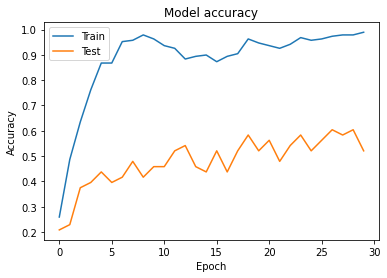

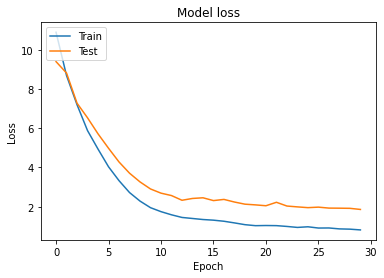

Training Accuracy: 90.2953565120697
Test Accuracy: 50.0


In [ ]:
data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

train_acc, test_acc = train(cnn2, sub_idx=0, data=data, num_epoch=30)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### Optimize across all subjects

Epoch 1/50
159/159 [==============================] - 4s 11ms/step - loss: 5.3067 - categorical_accuracy: 0.3128 - val_loss: 1.5229 - val_categorical_accuracy: 0.3191
Epoch 2/50
159/159 [==============================] - 1s 8ms/step - loss: 1.5284 - categorical_accuracy: 0.3086 - val_loss: 1.6839 - val_categorical_accuracy: 0.3018
Epoch 3/50
159/159 [==============================] - 1s 8ms/step - loss: 1.5451 - categorical_accuracy: 0.3028 - val_loss: 1.5420 - val_categorical_accuracy: 0.2829
Epoch 4/50
159/159 [==============================] - 1s 8ms/step - loss: 1.5069 - categorical_accuracy: 0.2891 - val_loss: 1.5357 - val_categorical_accuracy: 0.2908
Epoch 5/50
159/159 [==============================] - 1s 8ms/step - loss: 1.5030 - categorical_accuracy: 0.2816 - val_loss: 1.5302 - val_categorical_accuracy: 0.2561
Epoch 6/50
159/159 [==============================] - 1s 8ms/step - loss: 1.4953 - categorical_accuracy: 0.2857 - val_loss: 1.5069 - val_categorical_accuracy: 0.2924
Epo

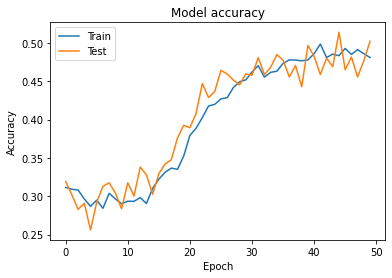

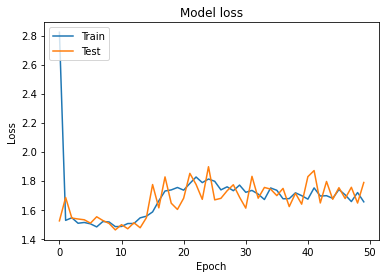

Training Accuracy: 53.58549952507019
Test Accuracy: 41.76072180271149


In [ ]:
data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

train_acc, test_acc = train(CNN_GRU, data=data, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### Optimize as a function of time

Time Period = 200
Epoch 1/20
53/53 [==============================] - 3s 29ms/step - loss: 4.1673 - categorical_accuracy: 0.3123 - val_loss: 1.9667 - val_categorical_accuracy: 0.4208
Epoch 2/20
53/53 [==============================] - 1s 21ms/step - loss: 1.7528 - categorical_accuracy: 0.4713 - val_loss: 1.5761 - val_categorical_accuracy: 0.4563
Epoch 3/20
53/53 [==============================] - 1s 22ms/step - loss: 1.4939 - categorical_accuracy: 0.4920 - val_loss: 1.5676 - val_categorical_accuracy: 0.4634
Epoch 4/20
53/53 [==============================] - 1s 21ms/step - loss: 1.4622 - categorical_accuracy: 0.5365 - val_loss: 1.5066 - val_categorical_accuracy: 0.4870
Epoch 5/20
53/53 [==============================] - 1s 21ms/step - loss: 1.3797 - categorical_accuracy: 0.5805 - val_loss: 1.4845 - val_categorical_accuracy: 0.5272
Epoch 6/20
53/53 [==============================] - 1s 21ms/step - loss: 1.3661 - categorical_accuracy: 0.6061 - val_loss: 1.5148 - val_categorical_accuracy:

Text(0.5, 1.0, 'Accuracies with Different Time Periods')

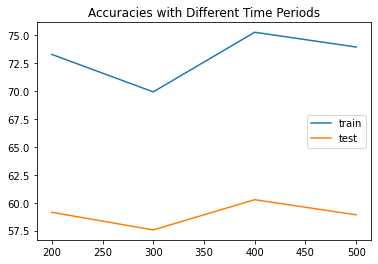

In [ ]:
train_scores = []
test_scores = []
# times = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
times = [200, 300, 400, 500]

data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

for t in times:
  print("Time Period = %d" %(t))
  train_acc, test_acc = train(cnn2, time_period=t, data=data, num_epoch=20, plot=False)
  train_scores.append(train_acc)
  test_scores.append(test_acc)

plt.plot(times, train_scores, label='train')
plt.plot(times, test_scores, label='test')
plt.legend()
plt.title("Accuracies with Different Time Periods")

### Compare Data Processing Technique

In [ ]:
data1 = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}
train_acc, test_acc = train(cnn2, time_period=200, data=data1, num_epoch=20, plot=False)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

data2 = {
    'X_train': X_train_gaussian,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}
train_acc, test_acc = train(cnn2, time_period=200, data=data2, num_epoch=20, plot=False)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Epoch 1/20
53/53 [==============================] - 2s 27ms/step - loss: 4.1377 - categorical_accuracy: 0.3269 - val_loss: 1.9744 - val_categorical_accuracy: 0.3877
Epoch 2/20
53/53 [==============================] - 1s 21ms/step - loss: 1.7461 - categorical_accuracy: 0.4527 - val_loss: 1.5525 - val_categorical_accuracy: 0.4752
Epoch 3/20
53/53 [==============================] - 1s 21ms/step - loss: 1.5045 - categorical_accuracy: 0.5107 - val_loss: 1.5493 - val_categorical_accuracy: 0.5130
Epoch 4/20
53/53 [==============================] - 1s 21ms/step - loss: 1.4902 - categorical_accuracy: 0.5166 - val_loss: 1.5364 - val_categorical_accuracy: 0.4870
Epoch 5/20
53/53 [==============================] - 1s 21ms/step - loss: 1.4625 - categorical_accuracy: 0.5266 - val_loss: 1.4775 - val_categorical_accuracy: 0.5083
Epoch 6/20
53/53 [==============================] - 1s 21ms/step - loss: 1.3984 - categorical_accuracy: 0.5868 - val_loss: 1.5196 - val_categorical_accuracy: 0.5177
Epoch 7/20